In [1]:
# Import external libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

# Import created files
import zomato_scripts as helpers

plt.style.use('ggplot')

In [2]:
# Allows for .py files to automatically reload.
%reload_ext autoreload
%autoreload 2

In [3]:
zom_df = pd.read_csv('../../data/zomato/zomato.csv')

In [4]:
zom_df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


# Cleaning the Data

### Formatting the Data of Restaurants with Ratings

Let's see how ratings are formatted.

In [5]:
zom_df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

Because the ratings are strings, we will need to convert them to floats.

In [6]:
# First, we will need to remove the space in between the numerator and the '/'.
zom_df['rate'] = zom_df['rate'].str.replace(' ', '')

# Then, remove the '/5' from the string.
zom_df['rate'] = zom_df['rate'].str.replace('/5', '')

In [7]:
zom_df['rate'].unique()

array(['4.1', '3.8', '3.7', '3.6', '4.6', '4.0', '4.2', '3.9', '3.1',
       '3.0', '3.2', '3.3', '2.8', '4.4', '4.3', 'NEW', '2.9', '3.5', nan,
       '2.6', '3.4', '4.5', '2.5', '2.7', '4.7', '2.4', '2.2', '2.3', '-',
       '4.8', '4.9', '2.1', '2.0', '1.8'], dtype=object)

In [8]:
# Adding .copy() at the end fixes the SettingCopyWithWarning warning.
# We will have to analyze new restaurants separately.

zom_df_floats = zom_df[(zom_df['rate'] != 'NEW') & (zom_df['rate'] != '-')].copy()
zom_df_floats['rate'] = zom_df_floats['rate'].astype(float)

Now, we will replace 'Yes' values with 1, and 'No' values with 0.

In [9]:
zom_df_floats['online_order'] = zom_df_floats['online_order'].replace(('Yes', 'No'), (1, 0))

In [10]:
zom_df_floats['book_table'] = zom_df_floats['book_table'].replace(('Yes', 'No'), (1, 0))

Now, we will convert the 'approx_cost(for two people)' column to numerical values.

In [11]:
zom_df_floats['approx_cost(for two people)'] = zom_df_floats['approx_cost(for two people)'].str.replace(',', '')

In [12]:
# Using .astype(float) to account for nan values.
zom_df_floats['approx_cost(for two people)'] = zom_df_floats['approx_cost(for two people)'].astype(float)

Let us see how the 'rest_types' column is formatted.

In [13]:
zom_df_floats['rest_type'].unique()

array(['Casual Dining', 'Cafe, Casual Dining', 'Quick Bites',
       'Casual Dining, Cafe', 'Cafe', 'Quick Bites, Cafe',
       'Cafe, Quick Bites', 'Delivery', 'Mess', 'Dessert Parlor',
       'Bakery, Dessert Parlor', 'Pub', 'Bakery', 'Takeaway, Delivery',
       'Fine Dining', 'Beverage Shop', 'Sweet Shop', 'Bar',
       'Beverage Shop, Quick Bites', 'Confectionery',
       'Quick Bites, Beverage Shop', 'Dessert Parlor, Sweet Shop',
       'Bakery, Quick Bites', 'Sweet Shop, Quick Bites', 'Kiosk',
       'Food Truck', 'Quick Bites, Dessert Parlor',
       'Beverage Shop, Dessert Parlor', 'Takeaway', 'Pub, Casual Dining',
       'Casual Dining, Bar', 'Dessert Parlor, Beverage Shop',
       'Quick Bites, Bakery', 'Dessert Parlor, Quick Bites',
       'Microbrewery, Casual Dining', 'Lounge', 'Bar, Casual Dining',
       'Food Court', 'Cafe, Bakery', nan, 'Dhaba',
       'Quick Bites, Sweet Shop', 'Microbrewery',
       'Food Court, Quick Bites', 'Pub, Bar', 'Casual Dining, Pub',
      

In [14]:
# Replacing the nan values with 'NA'
zom_df_floats['rest_type'] = zom_df_floats['rest_type'].fillna('NA')

In [15]:
# This gives each restaurant its first rest_type in its own column.

split_rest_types = lambda df: df['rest_type'].split(',')[0]
zom_df_floats['rest_type_single'] = zom_df_floats.apply(split_rest_types, axis = 1)

In [16]:
len(zom_df_floats['rest_type_single'].unique())

24

Now, to simplify the number of unique cuisines, we will give each restaurant its first cuisine type.

In [17]:
split_cuisines = lambda df: df['cuisines'].split(',')[0]

zom_df_floats['cuisines'] = zom_df_floats['cuisines'].fillna('NA')

In [18]:
zom_df_floats['cuisine_single'] = zom_df_floats.apply(split_cuisines, axis = 1)

Now, let us add the latitude and longitude to the restaurants in the dataframe.

In [19]:
geolocator = Nominatim(timeout = 10, user_agent = 'my_geolocator')

In [20]:
# Giving the new dataframe a column named 'location' makes merging easier.
locations = pd.DataFrame({'location' : zom_df['location'].unique()})

In [21]:
locations['location'] = locations['location'].apply(lambda x: str(x) + ', Bangalore')

In [22]:
lat_long = []

for location in locations['location']:
    location = geolocator.geocode(location)
    
    if location is None:
        lat_long.append(np.nan)
    else:
        geo = (location.latitude, location.longitude)
        lat_long.append(geo)

In [23]:
locations['geo_loc'] = lat_long

In [24]:
locations['location'] = locations['location'].apply(lambda x: x.replace(', Bangalore', '')[0:])

In [25]:
locations

,location,geo_loc
0,Banashankari,"(12.9152208, 77.573598)"
1,Basavanagudi,"(12.9417261, 77.5755021)"
2,Mysore Road,"(12.9455407, 77.5286919)"
3,Jayanagar,"(12.9292731, 77.5824229)"
4,Kumaraswamy Layout,"(12.9081487, 77.5553179)"
...,...,...
89,West Bangalore,"(12.9164172, 77.6516188)"
90,Magadi Road,"(12.9736861, 77.5502104)"
91,Yelahanka,"(13.1006982, 77.5963454)"
92,Sahakara Nagar,"(12.925455, 77.485201)"


In [26]:
zom_df_floats = zom_df_floats.merge(locations, on = 'location', how = 'left')

In [27]:
zom_df_floats['geo_loc'].isna().value_counts()

False    49389
True        51
Name: geo_loc, dtype: int64

In [28]:
zom_df_floats = zom_df_floats[zom_df_floats['geo_loc'].notna()]

In [29]:
# Create individual 'lat' and 'long' columns
zom_df_floats['lat'] = zom_df_floats['geo_loc'].apply(lambda x: x[0])
zom_df_floats['long'] = zom_df_floats['geo_loc'].apply(lambda x: x[1])

### Creating the New Restaurants DataFrame

In [30]:
new_rests = zom_df[zom_df['rate'] == 'NEW'].copy()

In [31]:
new_rests.head(10)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
72,https://www.zomato.com/bangalore/spicy-tandoor...,"Opposite ICICi Bank, Hanuman Nagar, Banashanka...",Spicy Tandoor,No,No,NEW,0,+91 8050884222,Banashankari,Quick Bites,NaN,North Indian,150,"[('Rated 4.0', 'RATED\n cost for chicken roll...",[],Delivery,Banashankari
75,https://www.zomato.com/bangalore/om-sri-vinaya...,"39, S B M Colony, Near-Sita Circle, 1st Stage,...",Om Sri Vinayaka Chats,No,No,NEW,0,+91 8553206035,Banashankari,"Takeaway, Delivery",NaN,"Street Food, Fast Food",500,[],[],Delivery,Banashankari
110,https://www.zomato.com/bangalore/hari-super-sa...,"594, 24 The Cross BSK, Opposte Oriental Bank, ...",Hari Super Sandwich,No,No,NEW,0,+91 9886722163,Banashankari,"Takeaway, Delivery",NaN,"Sandwich, Pizza, Beverages",200,"[('Rated 1.0', 'RATED\n I have been here many...",[],Delivery,Banashankari
130,https://www.zomato.com/bangalore/roll-magic-fa...,"28, 4th Cross Road, Dwaraka Nagar, Banashankar...",Roll Magic Fast Food,No,No,NEW,0,+91 9731409204,Banashankari,"Takeaway, Delivery",NaN,"Biryani, Rolls, Chinese",200,[],[],Delivery,Banashankari
131,https://www.zomato.com/bangalore/foodlieious-m...,"3/16, 22 Main Road, Magenta Block, PES College...",Foodlieious Multi Cuisine,No,No,NEW,0,+91 9168753522\r\n+91 8217877100,Banashankari,Quick Bites,NaN,North Indian,100,[],[],Delivery,Banashankari
132,https://www.zomato.com/bangalore/thanishka-nat...,"17/1, Ramaiah Garden, Kadirenahalli Circle, Dr...",Thanishka Nati And Karavali Style,No,No,NEW,0,+91 9108823881\r\n+91 8722229336,Banashankari,Quick Bites,NaN,"Biryani, Fast Food",400,[],[],Delivery,Banashankari
143,https://www.zomato.com/bangalore/melting-melod...,"Bhuvaneshwari Nagar BSK 3RD Stage, Banashankar...",Melting Melodies,No,No,NEW,0,+91 8970474798\r\n+91 8747977555,Banashankari,"Takeaway, Delivery",NaN,"Pizza, Fast Food",100,[],[],Delivery,Banashankari
144,https://www.zomato.com/bangalore/new-indrapras...,"77, 50 Ft Road, Hanumathnagara, Banashankari, ...",New Indraprasta,No,No,NEW,0,+91 8867333003,Banashankari,Quick Bites,NaN,"South Indian, Beverages",150,[],[],Delivery,Banashankari
154,https://www.zomato.com/bangalore/bitez-banasha...,"12, Banashankari, Bangalore",Bitez,No,No,NEW,0,+91 9916781796,Banashankari,Quick Bites,NaN,Fast Food,100,"[('Rated 1.0', ""RATED\n Not a good place. Ove...",[],Delivery,Banashankari
276,https://www.zomato.com/bangalore/ssv-upahar-ja...,"14/1, 8th Fmain, 3rd Block, Jayanagar, Bangalore",SSV Upahar,Yes,No,NEW,0,+91 7022622678,Jayanagar,Quick Bites,NaN,"South Indian, Chinese",300,[],"['Idli', 'Vada', 'Thatte Idli', 'Thatte Vada',...",Delivery,Banashankari


In [32]:
new_rests.loc[new_rests['online_order'] == 'No', 'online_order'] = 0
new_rests.loc[new_rests['online_order'] == 'Yes', 'online_order'] = 1

In [33]:
new_rests.loc[new_rests['book_table'] == 'No', 'book_table'] = 0
new_rests.loc[new_rests['book_table'] == 'Yes', 'book_table'] = 1

In [34]:
new_rests['rest_type'] = new_rests['rest_type'].fillna('NA')

In [35]:
new_rests['rest_type_single'] = new_rests.apply(split_rest_types, axis = 1)

In [36]:
new_rests['cuisine_single'] = new_rests.apply(split_cuisines, axis = 1)

In [37]:
new_rests = new_rests.merge(locations, on = 'location', how = 'left')

In [38]:
new_rests = new_rests[new_rests['geo_loc'].notna()]

In [39]:
new_rests['lat'] = new_rests['geo_loc'].apply(lambda x: x[0])
new_rests['long'] = new_rests['geo_loc'].apply(lambda x: x[1])

In [40]:
new_rests['approx_cost(for two people)'].isna().value_counts()

False    2205
True        1
Name: approx_cost(for two people), dtype: int64

In [41]:
new_rests = new_rests[new_rests['approx_cost(for two people)'].notna()]

In [42]:
new_rests['approx_cost(for two people)'] = new_rests['approx_cost(for two people)'].str.replace(',', '')

In [43]:
new_rests['approx_cost(for two people)'] = new_rests['approx_cost(for two people)'].apply(lambda x: float(x))

In [44]:
new_rests.head(10)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,...,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),rest_type_single,cuisine_single,geo_loc,lat,long
0,https://www.zomato.com/bangalore/spicy-tandoor...,"Opposite ICICi Bank, Hanuman Nagar, Banashanka...",Spicy Tandoor,0,0,NEW,0,+91 8050884222,Banashankari,Quick Bites,...,150.0,"[('Rated 4.0', 'RATED\n cost for chicken roll...",[],Delivery,Banashankari,Quick Bites,North Indian,"(12.9152208, 77.573598)",12.915221,77.573598
1,https://www.zomato.com/bangalore/om-sri-vinaya...,"39, S B M Colony, Near-Sita Circle, 1st Stage,...",Om Sri Vinayaka Chats,0,0,NEW,0,+91 8553206035,Banashankari,"Takeaway, Delivery",...,500.0,[],[],Delivery,Banashankari,Takeaway,Street Food,"(12.9152208, 77.573598)",12.915221,77.573598
2,https://www.zomato.com/bangalore/hari-super-sa...,"594, 24 The Cross BSK, Opposte Oriental Bank, ...",Hari Super Sandwich,0,0,NEW,0,+91 9886722163,Banashankari,"Takeaway, Delivery",...,200.0,"[('Rated 1.0', 'RATED\n I have been here many...",[],Delivery,Banashankari,Takeaway,Sandwich,"(12.9152208, 77.573598)",12.915221,77.573598
3,https://www.zomato.com/bangalore/roll-magic-fa...,"28, 4th Cross Road, Dwaraka Nagar, Banashankar...",Roll Magic Fast Food,0,0,NEW,0,+91 9731409204,Banashankari,"Takeaway, Delivery",...,200.0,[],[],Delivery,Banashankari,Takeaway,Biryani,"(12.9152208, 77.573598)",12.915221,77.573598
4,https://www.zomato.com/bangalore/foodlieious-m...,"3/16, 22 Main Road, Magenta Block, PES College...",Foodlieious Multi Cuisine,0,0,NEW,0,+91 9168753522\r\n+91 8217877100,Banashankari,Quick Bites,...,100.0,[],[],Delivery,Banashankari,Quick Bites,North Indian,"(12.9152208, 77.573598)",12.915221,77.573598
5,https://www.zomato.com/bangalore/thanishka-nat...,"17/1, Ramaiah Garden, Kadirenahalli Circle, Dr...",Thanishka Nati And Karavali Style,0,0,NEW,0,+91 9108823881\r\n+91 8722229336,Banashankari,Quick Bites,...,400.0,[],[],Delivery,Banashankari,Quick Bites,Biryani,"(12.9152208, 77.573598)",12.915221,77.573598
6,https://www.zomato.com/bangalore/melting-melod...,"Bhuvaneshwari Nagar BSK 3RD Stage, Banashankar...",Melting Melodies,0,0,NEW,0,+91 8970474798\r\n+91 8747977555,Banashankari,"Takeaway, Delivery",...,100.0,[],[],Delivery,Banashankari,Takeaway,Pizza,"(12.9152208, 77.573598)",12.915221,77.573598
7,https://www.zomato.com/bangalore/new-indrapras...,"77, 50 Ft Road, Hanumathnagara, Banashankari, ...",New Indraprasta,0,0,NEW,0,+91 8867333003,Banashankari,Quick Bites,...,150.0,[],[],Delivery,Banashankari,Quick Bites,South Indian,"(12.9152208, 77.573598)",12.915221,77.573598
8,https://www.zomato.com/bangalore/bitez-banasha...,"12, Banashankari, Bangalore",Bitez,0,0,NEW,0,+91 9916781796,Banashankari,Quick Bites,...,100.0,"[('Rated 1.0', ""RATED\n Not a good place. Ove...",[],Delivery,Banashankari,Quick Bites,Fast Food,"(12.9152208, 77.573598)",12.915221,77.573598
9,https://www.zomato.com/bangalore/ssv-upahar-ja...,"14/1, 8th Fmain, 3rd Block, Jayanagar, Bangalore",SSV Upahar,1,0,NEW,0,+91 7022622678,Jayanagar,Quick Bites,...,300.0,[],"['Idli', 'Vada', 'Thatte Idli', 'Thatte Vada',...",Delivery,Banashankari,Quick Bites,South Indian,"(12.9292731, 77.5824229)",12.929273,77.582423


In [45]:
new_rests['online_order'] = new_rests['online_order'].astype(float)
new_rests['book_table'] = new_rests['book_table'].astype(float)

In [46]:
new_rests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2205 entries, 0 to 2207
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   url                          2205 non-null   object 
 1   address                      2205 non-null   object 
 2   name                         2205 non-null   object 
 3   online_order                 2205 non-null   float64
 4   book_table                   2205 non-null   float64
 5   rate                         2205 non-null   object 
 6   votes                        2205 non-null   int64  
 7   phone                        2192 non-null   object 
 8   location                     2205 non-null   object 
 9   rest_type                    2205 non-null   object 
 10  dish_liked                   147 non-null    object 
 11  cuisines                     2205 non-null   object 
 12  approx_cost(for two people)  2205 non-null   float64
 13  reviews_list      

## Visualizing the Data of Restaurants with Ratings.

First, let us see the distribution of the ratings.

<AxesSubplot:title={'center':'Distribution of Ratings'}, xlabel='rate', ylabel='count'>

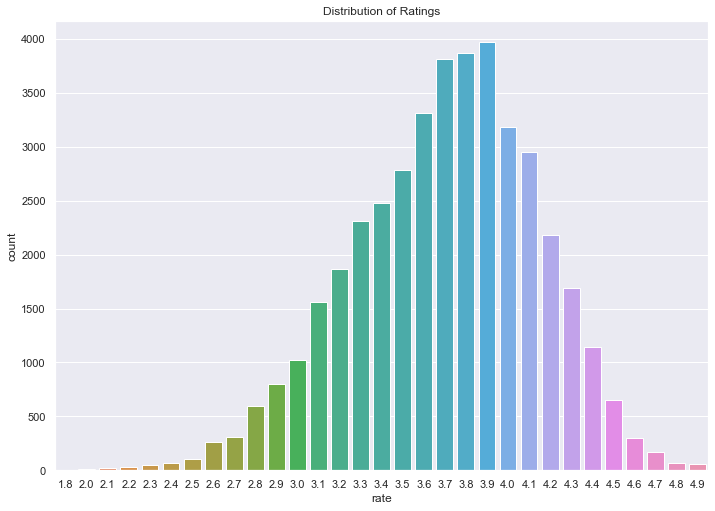

In [47]:
sns.set(rc = { 'figure.figsize':(11.7,8.27) }) # Sets figure size.

plt.title('Distribution of Ratings')

sns.countplot(
    x = 'rate',
    data = zom_df_floats
)

Now, let us see the correlations between the columns with numerical values.

<AxesSubplot:>

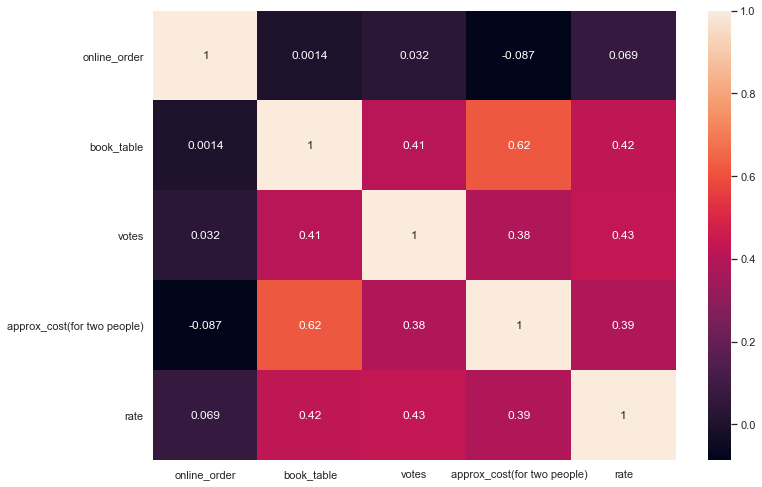

In [48]:
correlation_list = ['online_order', 'book_table', 'votes', 'approx_cost(for two people)', 'rate']
heatmap_data = zom_df_floats[correlation_list].corr()

sns.heatmap(heatmap_data, annot = True)

<AxesSubplot:xlabel='rate', ylabel='listed_in(type)'>

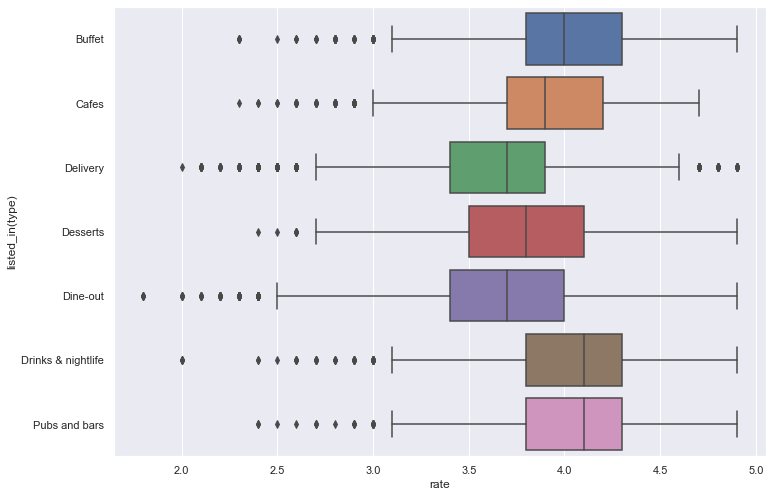

In [49]:
sns.boxplot(
    data = zom_df_floats,
    y = 'listed_in(type)', x = 'rate'
)

<AxesSubplot:xlabel='rate', ylabel='rest_type_single'>

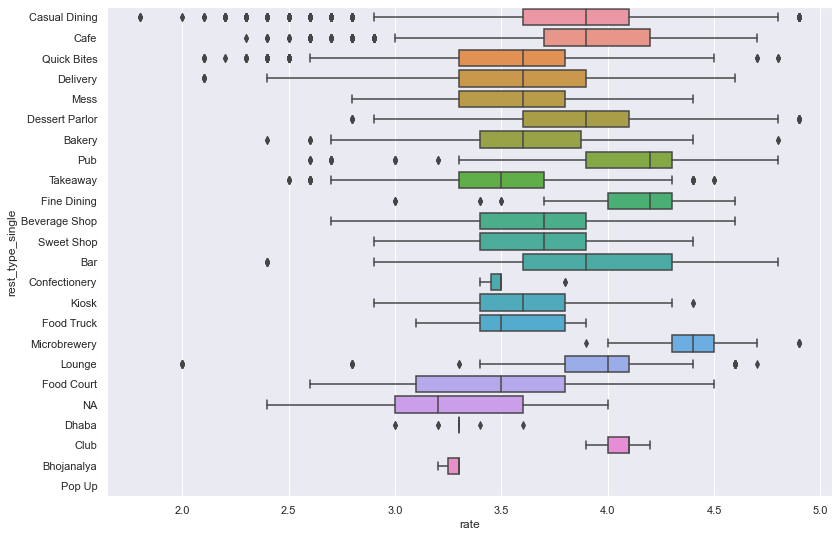

In [50]:
sns.set(rc = { 'figure.figsize':(13, 9) })

sns.boxplot(
    data = zom_df_floats,
    y = 'rest_type_single', x = 'rate'
)

Let us show a more detailed view of the relationship between rating and price.

<AxesSubplot:xlabel='rate', ylabel='approx_cost(for two people)'>

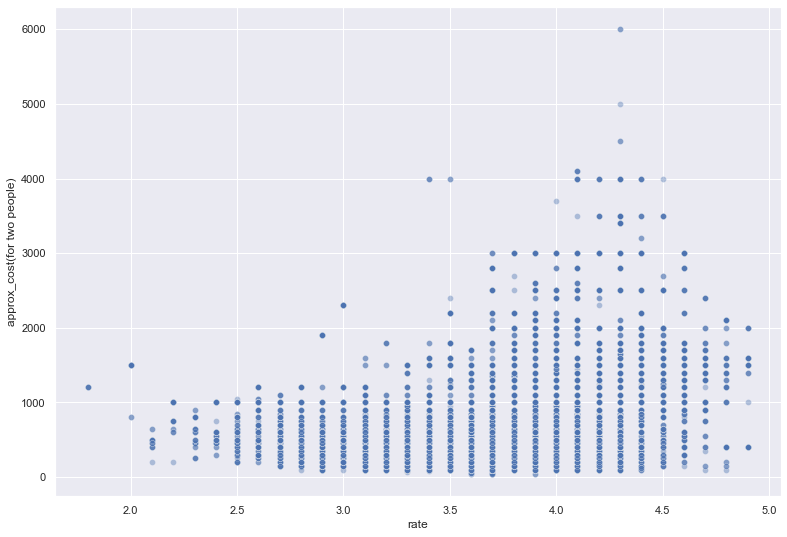

In [51]:
sns.scatterplot(
    data = zom_df_floats,
    x = 'rate', y = 'approx_cost(for two people)',
    alpha = 0.4
)

Which location has the most restaurants?

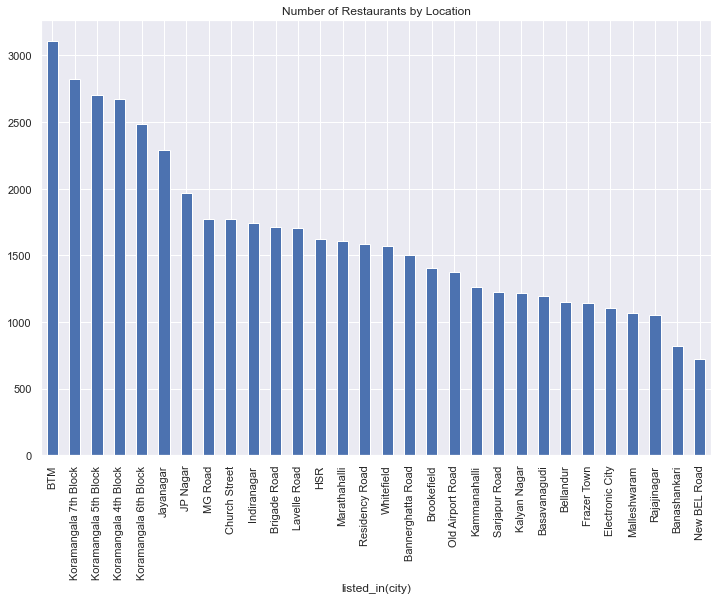

In [52]:
zom_df_floats.groupby(['listed_in(city)'])['address'].count().sort_values(
    ascending = False
    ).plot(
        kind = 'bar', figsize = (12, 8)
)
    
plt.title("Number of Restaurants by Location")
plt.show()

What is the relationship between cuisines and ratings?

In [53]:
zom_df_floats.groupby('cuisine_single').describe()[zom_df_floats.groupby('cuisine_single').describe()['rate']['count'] >= 200]['rate']

,count,mean,std,min,25%,50%,75%,max
cuisine_single,,,,,,,,
American,441.0,4.159410,0.340466,2.7,4.000,4.2,4.40,4.8
Andhra,980.0,3.577551,0.401104,2.0,3.300,3.6,3.80,4.3
Arabian,445.0,3.638652,0.405078,2.6,3.400,3.7,3.90,4.4
Asian,371.0,4.145553,0.436386,3.0,4.000,4.3,4.40,4.9
Bakery,1452.0,3.624518,0.378440,2.4,3.400,3.6,3.90,4.8
Bengali,339.0,3.628614,0.424307,2.1,3.400,3.7,3.90,4.5
Beverages,950.0,3.688632,0.335873,2.7,3.400,3.7,3.90,4.6
Biryani,2223.0,3.530859,0.394667,2.1,3.300,3.5,3.80,4.6
Burger,399.0,3.762406,0.371118,2.6,3.500,3.9,4.00,4.4


In [54]:
zom_df_floats.groupby('cuisine_single').describe()[zom_df_floats.groupby('cuisine_single').describe()['rate']['count'] < 200]['rate']

,count,mean,std,min,25%,50%,75%,max
cuisine_single,,,,,,,,
African,13.0,4.592308,2.773501e-02,4.5,4.600,4.60,4.600,4.6
Assamese,12.0,3.891667,3.604501e-01,3.2,3.850,4.10,4.100,4.1
Australian,5.0,3.800000,0.000000e+00,3.8,3.800,3.80,3.800,3.8
Awadhi,19.0,3.831579,3.590924e-01,3.5,3.500,3.50,4.200,4.2
BBQ,108.0,4.004630,3.216152e-01,3.3,3.700,4.10,4.300,4.8
Bar Food,8.0,3.062500,4.596194e-01,2.9,2.900,2.90,2.900,4.2
Belgian,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bihari,23.0,3.778261,2.729577e-01,3.5,3.550,3.70,4.000,4.2
Bohri,6.0,3.583333,4.082483e-02,3.5,3.600,3.60,3.600,3.6


What is the relationship between cost and cuisine?

In [55]:
zom_df_floats.groupby('cuisine_single').describe()['approx_cost(for two people)'][zom_df_floats.groupby('cuisine_single').describe()['approx_cost(for two people)']['count'] >= 200]

,count,mean,std,min,25%,50%,75%,max
cuisine_single,,,,,,,,
American,522.0,1209.099617,681.492768,200.0,600.0,1200.0,1500.0,3000.0
Andhra,1156.0,550.839100,208.824967,70.0,400.0,550.0,700.0,1500.0
Arabian,518.0,507.335907,241.357875,100.0,300.0,400.0,700.0,1500.0
Asian,395.0,1269.240506,643.897106,250.0,600.0,1400.0,1700.0,3000.0
Bakery,2065.0,389.181598,154.526215,50.0,300.0,400.0,500.0,1400.0
Bengali,378.0,487.698413,223.786427,150.0,300.0,400.0,600.0,1200.0
Beverages,1170.0,267.863248,166.048160,100.0,150.0,250.0,350.0,2000.0
Biryani,2880.0,417.461806,199.579400,100.0,300.0,400.0,600.0,1500.0
Burger,448.0,456.361607,145.816911,100.0,400.0,500.0,550.0,1000.0


In [56]:
zom_df_floats.groupby('cuisine_single').describe()['approx_cost(for two people)'][zom_df_floats.groupby('cuisine_single').describe()['approx_cost(for two people)']['count'].between(10, 199)]

,count,mean,std,min,25%,50%,75%,max
cuisine_single,,,,,,,,
African,13.0,1000.000000,0.000000,1000.0,1000.0,1000.0,1000.0,1000.0
Assamese,12.0,475.000000,45.226702,400.0,475.0,500.0,500.0,500.0
Awadhi,21.0,785.714286,639.754417,200.0,200.0,500.0,1500.0,1500.0
BBQ,113.0,877.433628,486.238806,200.0,400.0,750.0,1500.0,2000.0
Bihari,41.0,293.902439,73.480543,150.0,250.0,300.0,300.0,400.0
Burmese,14.0,385.714286,140.642169,300.0,300.0,300.0,525.0,600.0
Chettinad,102.0,746.078431,295.484689,200.0,600.0,650.0,737.5,1300.0
Coffee,11.0,481.818182,152.106422,150.0,550.0,550.0,550.0,550.0
Goan,77.0,977.272727,320.930540,400.0,800.0,1000.0,1000.0,1800.0


In [57]:
helpers.create_heatmap(zom_df_floats, 'cuisine_single', 'Street Food')

In [58]:
helpers.create_heatmap(zom_df_floats, 'rest_type_single', 'Casual Dining')

## Visualizing the Data of Restaurants Without Ratings

<AxesSubplot:>

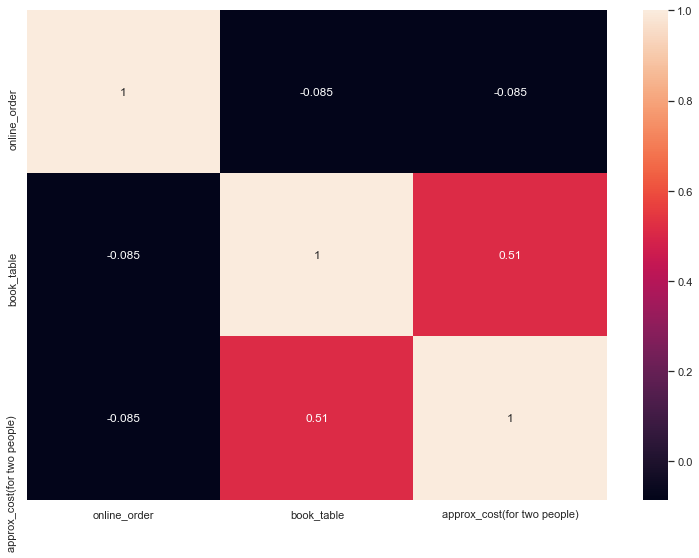

In [59]:
new_rests_correlation_list = ['online_order', 'book_table', 'approx_cost(for two people)']
heatmap_data_new_rests = new_rests[new_rests_correlation_list].corr()

sns.heatmap(heatmap_data_new_rests, annot = True)

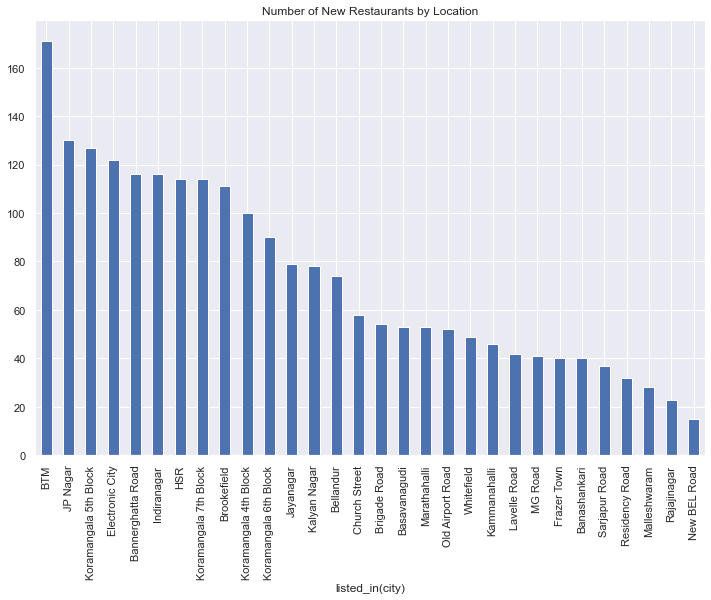

In [60]:
new_rests.groupby(['listed_in(city)'])['address'].count().sort_values(
    ascending = False
    ).plot(
        kind = 'bar', figsize = (12, 8)
)
    
plt.title("Number of New Restaurants by Location")
plt.show()

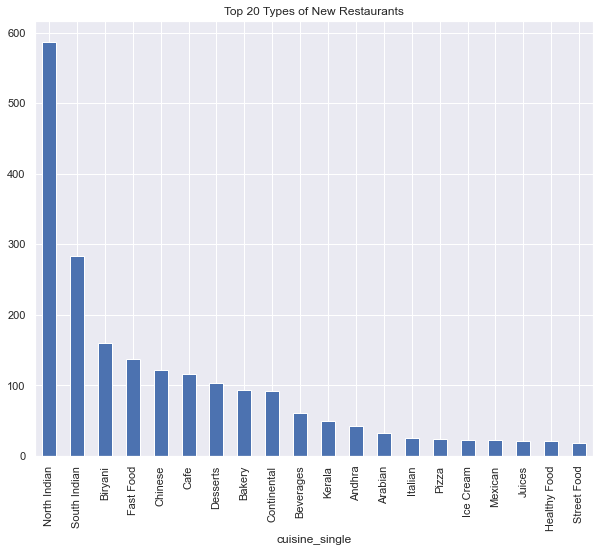

In [61]:
new_rests.groupby(['cuisine_single']).count()['address'].sort_values(
    ascending = False
    ).head(20).plot(
        kind = 'bar', figsize = (10, 8)
)

plt.title('Top 20 Types of New Restaurants')
plt.show()

In [62]:
new_rests.groupby('cuisine_single').describe()['approx_cost(for two people)'][new_rests.groupby('cuisine_single').describe()['approx_cost(for two people)']['count'] > 10]

,count,mean,std,min,25%,50%,75%,max
cuisine_single,,,,,,,,
Andhra,42.0,448.809524,209.380065,250.0,300.0,350.0,500.0,900.0
Arabian,33.0,389.393939,193.954560,200.0,250.0,400.0,400.0,850.0
Asian,13.0,807.692308,386.138012,300.0,400.0,800.0,1000.0,1400.0
Bakery,93.0,372.150538,162.720415,100.0,200.0,400.0,500.0,700.0
Bengali,12.0,366.666667,98.473193,200.0,300.0,400.0,400.0,500.0
Beverages,61.0,220.983607,78.266743,80.0,200.0,200.0,200.0,400.0
Biryani,160.0,399.750000,170.046054,160.0,300.0,350.0,500.0,800.0
Cafe,116.0,525.000000,234.196127,100.0,300.0,500.0,700.0,1100.0
Chinese,122.0,356.147541,143.679204,200.0,300.0,300.0,400.0,850.0


In [63]:
helpers.count_heatmap(new_rests)